# BERT Fine-Tuning (pure)

*By Asmik Nalmpatian and Lisa Wimmer*

*Last edited on 30.12.20* 

*For our consulting project: Aspect-Based Sentiment Analysis for Twitter Data of German MPs*

*Methodology based on: https://arxiv.org/pdf/1810.04805.pdf*

This notebook is supposed to give an overview over the used functionalities. We will show how to use BERT - Bidirectional Encoder Representations from Transformers - with PyTorch library (huggingface) to fine-tune a pretrained model in tweet classification. 

The following pretrained BERT models can be used and are available in transformers huggingface: 

*   *bert-base-german-cased (trained by Deepset.ai)*
*   *bert-base-german-dbmdz-cased (trained by by DBMDZ)*
*   *bert-base-german-dbmdz-uncased (trained by by DBMDZ)*
*   *distilbert-base-german-cased (distilled from DBMDZ)*

After using these models to extract (hopefully) high quality features from our text data, we aim to fine-tune them on our specific task using a manually labeled sample of German tweets to gain state of the art predictions.

All in all the tweets will be classified into *positive* and *negative* classes using a pretrained BERT model. We will take it, add an untrained layer of neurons on the end and train a new model specifically for classification task. 
Advantages of Fine-Tuning:  


*   Quick because we have already hardly pretrained layers of the network (only 2-4 epochs after adding 1 fully-connected layer on top are enough to train as the authors recommend)
*   Less data is sometimes enough to achieve good performance
*   Usually preferable results: Because of task-specific adjustments of the weights





# Google Colab GPU Connection

Otherwise training a large NN may take a very long time. 

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
# Identify and specify the GPU as the device
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
# Where to save our data
import os, sys

os.getcwd()

'/content'

# Fine-Tuning 

Install Huggingface Library / transformers package and specify the pretrained transformer model. (Uncased means that the texts have only lowercase letters)


In [6]:
!pip install transformers
from transformers import BertTokenizer

pretrained_model = "bert-base-german-cased"

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model)

     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 2.9MB 20.0MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=70aa5198144ea1ca0ba110c9c86db4dc787d4c5e0c06ca627cdd5bdfd6a92f24
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Loading BERT tokenizer...


Load and prepare the tweets and labels 

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("data-tweepy-df-subset-labeled-manually.csv" , delimiter=';',error_bad_lines=False)

df['label_binary'] = [1 if label == 'positive' else 0 for label in df.label]
df.head()

# Get the lists of tweets and their labels.
tweets = df.full_text.values
labels = df.label_binary.values

First, we need to tokenize our text to be able to feet it into the BERT model. 

Below an example of tokenized and raw tweet versions is shown. To tokenize the text we have to specify and use the pre-trained BERT because each model has a fixed vocabulary (containing tokens, so wordpieces) and the BERT tokenizer handles words which are not in the certain vocabulary in a specific way.

Each token is then mapped to their index in the tokenizer vocabulary

In [7]:
# Print the raw tweet.
print('Raw: ', tweets[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the tweet mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  @UweNess @jensspahn Ich halte diese These fuer puren Ableismus.
Tokenized:  ['@', 'Uwe', '##Ne', '##ss', '@', 'jen', '##ss', '##pa', '##hn', 'Ich', 'halte', 'diese', 'These', 'f', '##uer', 'pur', '##en', 'Ab', '##lei', '##sm', '##us', '.']
Token IDs:  [26991, 14588, 6547, 430, 26991, 3583, 430, 5028, 206, 1671, 15443, 620, 16649, 69, 667, 25143, 7, 226, 445, 6694, 51, 26914]


In the next step we add special tokens to the start *CLS* and end of each tweet *SEP*.

In [2]:
# Tokenize all of the tweets and map the tokens to their word IDs.
input_ids = []

# For every tweet...
for tweet in tweets:
    encoded_tweet = tokenizer.encode(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded tweet to the list.
    input_ids.append(encoded_tweet)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

NameError: ignored

Then we pad and truncate all tweets to a constant fixed length 

In [9]:
print('Max sentence length: ', max([len(tweet) for tweet in input_ids]))

Max sentence length:  91


In [10]:
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# A bit larger than the maximum training tweet length of 91...
MAX_LEN = 110

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" - pad and truncate at the end of the sequence, as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 110 values...

Padding token: "[PAD]", ID: 0

Done.


Create attention masks which indicates which tokens are words and which are padding (if token ID is 0 then it is padding and the attention mask is set to 0)

In [11]:
# Create attention masks
attention_masks = []

# For each sentence...
for tweet in input_ids:
    
    att_mask = [int(token_id > 0) for token_id in tweet]
    
    # Store the attention mask for each tweet.
    attention_masks.append(att_mask)

Now, we use train_test_split to split our data into train, test sets first  and then split the initial train set further into a final train set and validation set for training


In [12]:
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
train_inputs1, test_inputs, train_labels1, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.2)

# Do the same for the masks.
train_masks1, test_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2020, test_size=0.2)

# Use 20% of train set as validation set 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs1, train_labels1, 
                                                                                    test_size=0.2, random_state=2020) 

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(train_masks1, train_labels1,
                                             random_state=2020, test_size=0.2)    

Convert all inputs and labels into torch tensors, the required datatype 
for our model.

In [13]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

The torch DataLoader class enables to create  an iterator for our data in order to save memory during training process.

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define batch size here to let DataLoader know. 
# BERT-authors recommend a batch size of 16 or 32 for fine-tuning .

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


Load BertForSequenceClassification, the pretrained BERT model with a single 
linear classification layer on top. This is the one for classification tasks in general. *(see for more details https://huggingface.co/transformers/v2.2.0/model_doc/bert.html)*

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    pretrained_model, 
    num_labels = 2, # The number of output labels--2 for binary classification. Can be increased for multiclass
    output_attentions = False, 
    output_hidden_states = False, 
)

# Run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# All of the model's parameters as a list of tuples.
params = list(model.named_parameters())

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Get the optimizer after loading the model to train the hyperparameters. 

We chose following values based on authors' recommendations:

Batch size: 32 
Learning rate (Adam): 2e-5
Number of epochs: 4

*(see for more details on AdamW Optimizer https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)*

In [18]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [20]:
# helper function for calculating accuracy
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
# helper function for formatting elapsed times
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Let's start the actual training process

In [22]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 55

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch:
for epoch_i in range(0, epochs):
    
    ## TRAIN
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # how long does the training epoch take.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Turn on the training mode for the model. 
    model.train()

    # For each batch of training data:
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the batch and load onto the GPU.
        # Each batch contains input ids, attention masks, labels. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Remove any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        

        # Do a forward pass. 
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_loss += loss.item()

        # Do a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step.
        optimizer.step()

        scheduler.step()

    # Avg loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Need for plotting the learning curve later.
    loss_values.append(avg_train_loss)

    print("")
    print("  Avg training loss: {0:.2f}".format(avg_train_loss))
    print("  Epoch time: {:}".format(format_time(time.time() - t0)))
        
    ## VALIDATE
    # After each training epoch, we measure performance on
    # validation set.

    t0 = time.time()

    # Turn on the evaluation mode of the model.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get logit values predicted for each class.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Accuracy for this batch of validation tweets.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation time: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.47
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.43
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:00

Training complete!


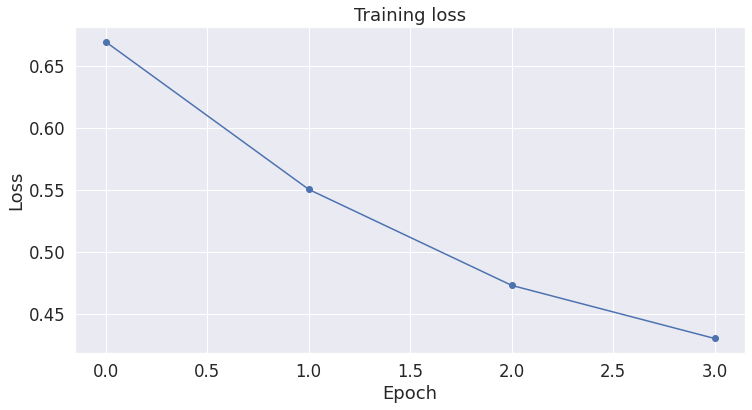

In [23]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Evaluate on Test Set

In [27]:
# Prediction on test set

print('Predicting labels for {:,} test tweets...'.format(len(test_inputs)))

# Turn on the evaluation mode of the model
model.eval()

predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Compute gradients, save memory and speed up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 47 test sentences...
    DONE.


In [36]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label_binary.sum(), len(df.label_binary), (df.label_binary.sum() / len(df.label_binary) * 100.0)))

Positive samples: 93 of 233 (39.91%)


Performance measures

In [61]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
# list of keys of the highest scores, i.e. predictions (indices of the maximum values along an axis)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

Calculate F1-Score, Accuracy and Show the Confusion Matrix

In [71]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

f1_value = f1_score(flat_predictions, flat_true_labels, average="weighted")
accuracy = accuracy_score(flat_predictions, flat_true_labels)

print("F1 Score (Weighted): {}".format(f1_value))
print("Accuracy: {}".format(accuracy))

F1 Score (Weighted): 0.7980809345014601
Accuracy: 0.7872340425531915


In [67]:
df.columns

Index(['doc_id', 'username', 'retweet_count', 'favorite_count', 'full_text',
       'label', 'topic', 'label_binary'],
      dtype='object')

In [79]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    cm = confusion_matrix(y_true=true_labels, 
                                  y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=[[0,0],[0,1]]), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=[[0,0],[0,1]])) 
    return cm_frame   

In [80]:
display_confusion_matrix(true_labels = flat_true_labels, predicted_labels = flat_predictions)

Predicted:    
                   1   0
Actual: 1         12   9
        0          1  25